<a href="https://colab.research.google.com/github/hosseindamavandi/NMA-Allen-Visual-Behavior-2p/blob/main/ERP_Cell_Feature_Classification_Models_LOMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/NMA-2025/project

/content/drive/MyDrive/NMA-2025/project


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, StratifiedGroupKFold, GroupKFold,
    LeaveOneGroupOut, cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    roc_curve, auc
)

# Try the new StratifiedGroupKFold; fall back to GroupKFold if not available
try:
    from sklearn.model_selection import StratifiedGroupKFold
    GROUP_CV = "StratifiedGroupKFold"
except ImportError:
    from sklearn.model_selection import GroupKFold
    GROUP_CV = "GroupKFold"

# Try importing XGBoost
try:
    from xgboost import XGBClassifier
except ImportError:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "xgboost"])
    from xgboost import XGBClassifier

In [5]:
# 1) Load the dataset
df = pd.read_csv('erp_per-cell_features_extracted.csv')

In [6]:
# 2) Dataset dimensions
n_rows, n_cols = df.shape
print(f"Dataset shape: {n_rows} rows, {n_cols} columns")

Dataset shape: 640 rows, 21 columns


In [7]:
# 3) Missing-value inspection
missing = df.isnull().sum()
print("Missing values per column:")
print(missing[missing > 0] if missing.sum() > 0 else "No missing values")

Missing values per column:
No missing values


In [8]:
# 4) Data types
print("\nData types:")
print(df.dtypes)


Data types:
cell_specimen_id      int64
cre_line             object
omitted                bool
exposure_level       object
mouse_id              int64
AUC                 float64
PeakAmplitude       float64
LatencyToPeak       float64
TroughAmplitude     float64
LatencyToTrough     float64
PeakToTrough        float64
Slope_0_200ms       float64
FWHM                float64
Energy              float64
Mean_0_500ms        float64
Mean_500_1000ms     float64
Skewness            float64
Kurtosis            float64
ZeroCrossings         int64
RiseTime_10to90     float64
DecayTime_Half      float64
dtype: object


In [9]:
# 5) Target-class distribution
class_dist = df['omitted'].value_counts()
print("Target ('omitted') class distribution:")
print(class_dist)
print(f"\nProportion of positive class: {class_dist.get(True, 0) / len(df):.2%}")

Target ('omitted') class distribution:
omitted
False    320
True     320
Name: count, dtype: int64

Proportion of positive class: 50.00%


In [10]:
# Define target and features
y = df['omitted']
X = df.drop(columns=['omitted']).copy()

In [11]:
# Pre-processing pipeline
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='drop'
)

In [13]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

In [14]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (512, 20), Test shape: (128, 20)


In [15]:
# Group-aware 5-fold CV setup
groups = X['mouse_id']

In [16]:
logo = LeaveOneGroupOut()
cv_groups = list(logo.split(X, y, groups=groups))

In [17]:
print(f"Using {GROUP_CV} with {len(cv_groups)} folds.")

Using StratifiedGroupKFold with 13 folds.


In [18]:
for i, (tr_idx, val_idx) in enumerate(cv_groups, 1):
    n_pos = y.iloc[val_idx].sum()
    n_total = len(val_idx)
    print(f"  Fold {i}: {n_total} samples, positives = {int(n_pos)}")

  Fold 1: 34 samples, positives = 17
  Fold 2: 86 samples, positives = 43
  Fold 3: 40 samples, positives = 20
  Fold 4: 36 samples, positives = 18
  Fold 5: 72 samples, positives = 36
  Fold 6: 42 samples, positives = 21
  Fold 7: 14 samples, positives = 7
  Fold 8: 64 samples, positives = 32
  Fold 9: 16 samples, positives = 8
  Fold 10: 26 samples, positives = 13
  Fold 11: 56 samples, positives = 28
  Fold 12: 132 samples, positives = 66
  Fold 13: 22 samples, positives = 11


In [19]:
df.head()

,cell_specimen_id,cre_line,omitted,exposure_level,mouse_id,AUC,PeakAmplitude,LatencyToPeak,TroughAmplitude,LatencyToTrough,...,Slope_0_200ms,FWHM,Energy,Mean_0_500ms,Mean_500_1000ms,Skewness,Kurtosis,ZeroCrossings,RiseTime_10to90,DecayTime_Half
0,1086489847,Vip-IRES-Cre,False,familiar,486737,0.001156,0.006611,0.314607,-0.003816,1.022472,...,-0.003303,0.842697,0.000512,0.003253,0.001879,0.529877,-0.219510,20,1.314607,0.168539
1,1086489847,Vip-IRES-Cre,False,novel,486737,0.018161,0.027589,0.584270,-0.006884,0.078652,...,0.046827,0.977528,0.010294,0.010388,0.014589,0.777351,-0.457898,11,1.449438,0.202247
2,1086489847,Vip-IRES-Cre,True,familiar,486737,0.008858,0.011794,0.820225,-0.005546,-0.224719,...,-0.017613,0.910112,0.002140,0.000194,0.008266,0.416573,-0.407229,9,1.719101,0.235955
3,1086489847,Vip-IRES-Cre,True,novel,486737,0.002576,0.015562,1.056180,-0.006281,0.280899,...,-0.009213,1.584270,0.002281,-0.003856,-0.000034,1.020190,0.469992,9,2.056180,0.303371
4,1086489860,Vip-IRES-Cre,False,familiar,486737,0.000282,0.008663,-0.730337,-0.011890,1.258427,...,-0.022773,1.483146,0.001259,0.002677,0.003004,-0.162385,0.566323,14,0.269663,0.101124


## Logistic Regression – Leave-One-Mouse-Out CV

In [20]:
# Build pipeline
log_reg = LogisticRegression(max_iter=1000, random_state=42)

pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', log_reg)
])

In [21]:
# Leave-One-Mouse-Out CV (accuracy)
cv_acc = cross_val_score(
    pipe, X, y,
    cv=cv_groups,
    scoring='accuracy',
    n_jobs=-1
)
print(f"LOMO Accuracy: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")

LOMO Accuracy: 0.902 ± 0.087


In [22]:
# Fit on full training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['cell_specimen_id',
                                                   'mouse_id', 'AUC',
                                                   'PeakAmplitude',
                                                   'LatencyToPeak',
                                                   'TroughAmplitude',
                                                   'LatencyToTrough',
                                                   'PeakToTrough',
                                                   'Slope_0_200ms', 'FWHM',
                                                   'Energy', 'Mean_0_500ms',
                                                   'Mean_500_1000ms',
                                                   'Skewness', 'Kurtosis',
                                                   'ZeroCrossings',
                                                   'RiseTime_10to90',
                                                   'DecayTime_Half']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cre_line',
                                                   'exposure_level'])])),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])

In [23]:
# Predictions & probabilities on Test
y_pred   = pipe.predict(X_test)
y_scores = pipe.predict_proba(X_test)[:, 1]

In [24]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_scores)

In [25]:
print("Test-set metrics:")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1-Score : {f1:.3f}")
print(f"  ROC-AUC  : {roc:.3f}")

Test-set metrics:
  Accuracy : 0.953
  Precision: 1.000
  Recall   : 0.906
  F1-Score : 0.951
  ROC-AUC  : 0.984


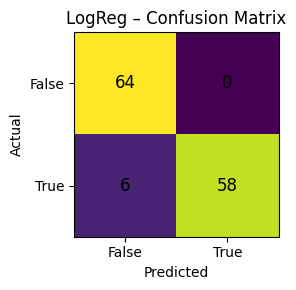

In [26]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
plt.imshow(cm, interpolation='nearest')
plt.title("LogReg – Confusion Matrix")
plt.xticks([0,1], ['False', 'True'])
plt.yticks([0,1], ['False', 'True'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, v, ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

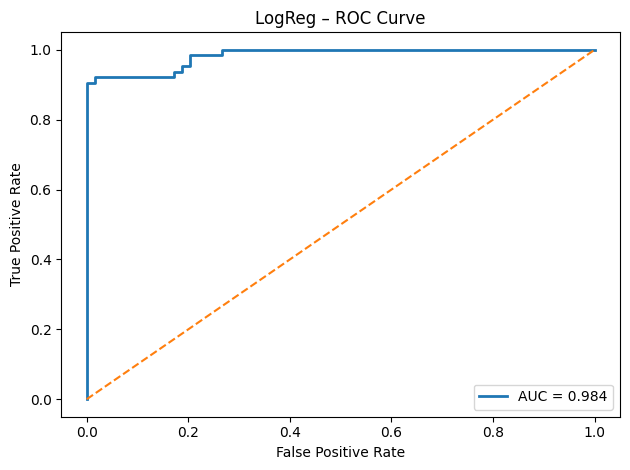

In [27]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], ls='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title("LogReg – ROC Curve")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

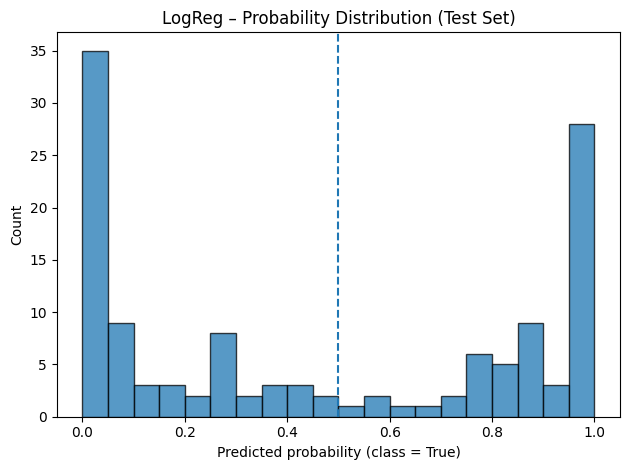

In [28]:
# Probability Distribution
plt.figure()
plt.hist(y_scores, bins=20, edgecolor='black', alpha=0.75)
plt.axvline(0.5, ls='--')
plt.xlabel('Predicted probability (class = True)')
plt.ylabel('Count')
plt.title("LogReg – Probability Distribution (Test Set)")
plt.tight_layout()
plt.show()

## Decision Tree – Leave-One-Mouse-Out CV

In [29]:
# Build pipeline
dtree = DecisionTreeClassifier(
    max_depth=None,
    random_state=42
)

pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', dtree)
])

In [30]:
# Leave-One-Mouse-Out CV (accuracy)
cv_acc = cross_val_score(
    pipe, X, y,
    cv=cv_groups,
    scoring='accuracy',
    n_jobs=-1
)
print(f"LOMO Accuracy: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")

LOMO Accuracy: 0.890 ± 0.059


In [31]:
# Fit on full training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['cell_specimen_id',
                                                   'mouse_id', 'AUC',
                                                   'PeakAmplitude',
                                                   'LatencyToPeak',
                                                   'TroughAmplitude',
                                                   'LatencyToTrough',
                                                   'PeakToTrough',
                                                   'Slope_0_200ms', 'FWHM',
                                                   'Energy', 'Mean_0_500ms',
                                                   'Mean_500_1000ms',
                                                   'Skewness', 'Kurtosis',
                                                   'ZeroCrossings',
                                                   'RiseTime_10to90',
                                                   'DecayTime_Half']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cre_line',
                                                   'exposure_level'])])),
                ('clf', DecisionTreeClassifier(random_state=42))])

In [32]:
# Predictions & probabilities on Test
y_pred   = pipe.predict(X_test)
y_scores = pipe.predict_proba(X_test)[:, 1]

In [33]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_scores)

In [34]:
print("Test-set metrics:")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1-Score : {f1:.3f}")
print(f"  ROC-AUC  : {roc:.3f}")

Test-set metrics:
  Accuracy : 0.938
  Precision: 0.938
  Recall   : 0.938
  F1-Score : 0.938
  ROC-AUC  : 0.938


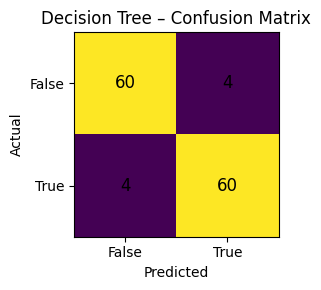

In [35]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
plt.imshow(cm, interpolation='nearest')
plt.title("Decision Tree – Confusion Matrix")
plt.xticks([0,1], ['False', 'True'])
plt.yticks([0,1], ['False', 'True'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, v, ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

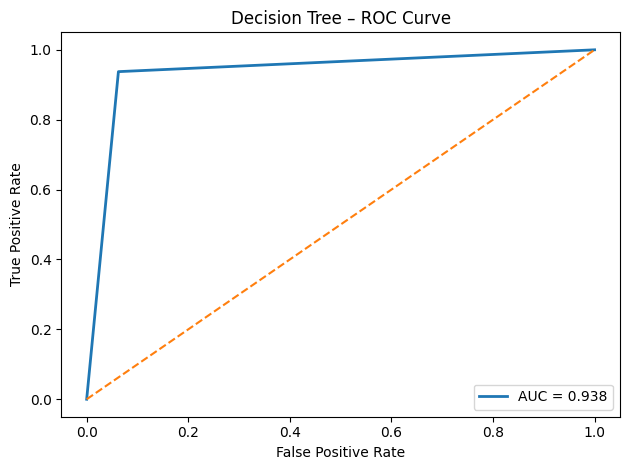

In [36]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], ls='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title("Decision Tree – ROC Curve")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

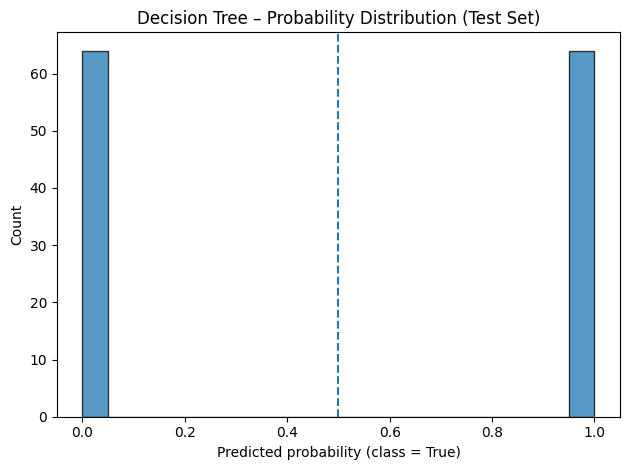

In [37]:
# Probability Distribution
plt.figure()
plt.hist(y_scores, bins=20, edgecolor='black', alpha=0.75)
plt.axvline(0.5, ls='--')
plt.xlabel('Predicted probability (class = True)')
plt.ylabel('Count')
plt.title("Decision Tree – Probability Distribution (Test Set)")
plt.tight_layout()
plt.show()

## Random Forest – Leave-One-Mouse-Out CV

In [38]:
# Build pipeline
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', rf)
])

In [39]:
#Leave-One-Mouse-Out CV (accuracy)
cv_acc = cross_val_score(
    pipe, X, y,
    cv=cv_groups,            # 13 folds = 13 mice
    scoring='accuracy',
    n_jobs=-1
)
print(f"LOMO Accuracy: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")

LOMO Accuracy: 0.931 ± 0.057


In [40]:
# Fit on full training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['cell_specimen_id',
                                                   'mouse_id', 'AUC',
                                                   'PeakAmplitude',
                                                   'LatencyToPeak',
                                                   'TroughAmplitude',
                                                   'LatencyToTrough',
                                                   'PeakToTrough',
                                                   'Slope_0_200ms', 'FWHM',
                                                   'Energy', 'Mean_0_500ms',
                                                   'Mean_500_1000ms',
                                                   'Skewness', 'Kurtosis',
                                                   'ZeroCrossings',
                                                   'RiseTime_10to90',
                                                   'DecayTime_Half']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cre_line',
                                                   'exposure_level'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                        random_state=42))])

In [41]:
# Predictions & probabilities on Test
y_pred   = pipe.predict(X_test)
y_scores = pipe.predict_proba(X_test)[:, 1]

In [42]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_scores)

In [43]:
print("Test-set metrics:")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1-Score : {f1:.3f}")
print(f"  ROC-AUC  : {roc:.3f}")

Test-set metrics:
  Accuracy : 0.969
  Precision: 0.984
  Recall   : 0.953
  F1-Score : 0.968
  ROC-AUC  : 0.998


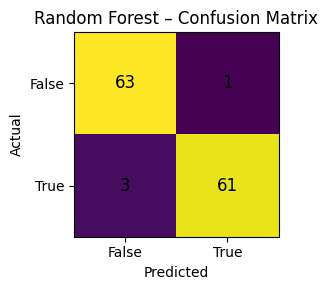

In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
plt.imshow(cm, interpolation='nearest')
plt.title("Random Forest – Confusion Matrix")
plt.xticks([0,1], ['False', 'True'])
plt.yticks([0,1], ['False', 'True'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, v, ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

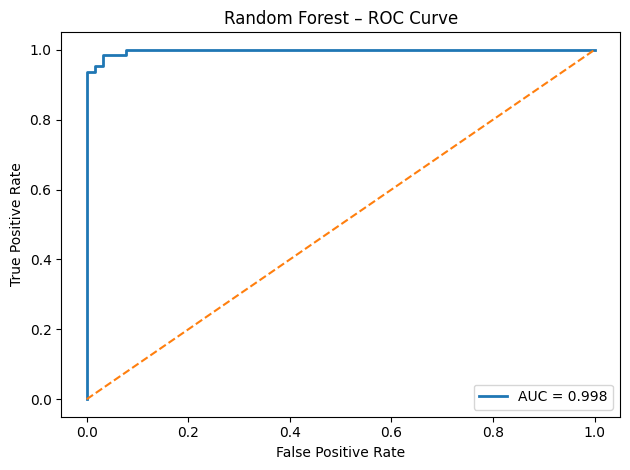

In [45]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], ls='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title("Random Forest – ROC Curve")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

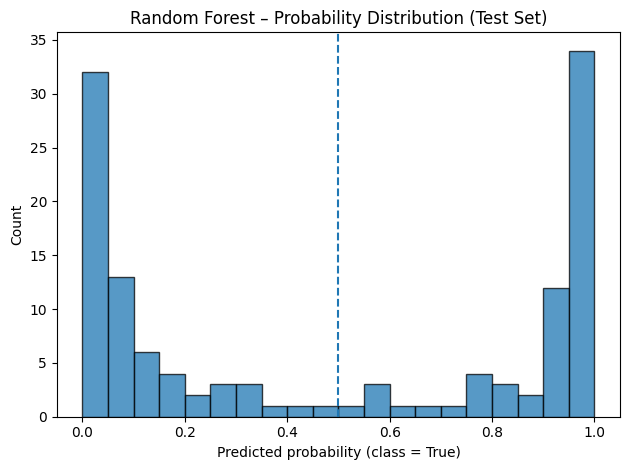

In [46]:
# Probability Distribution
plt.figure()
plt.hist(y_scores, bins=20, edgecolor='black', alpha=0.75)
plt.axvline(0.5, ls='--')
plt.xlabel('Predicted probability (class = True)')
plt.ylabel('Count')
plt.title("Random Forest – Probability Distribution (Test Set)")
plt.tight_layout()
plt.show()

## SVM (RBF) – Leave-One-Mouse-Out CV

In [47]:
# Build pipeline
svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', svm)
])

In [48]:
# Leave-One-Mouse-Out CV (accuracy)
cv_acc = cross_val_score(
    pipe, X, y,
    cv=cv_groups,
    scoring='accuracy',
    n_jobs=-1
)
print(f"LOMO Accuracy: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")

LOMO Accuracy: 0.880 ± 0.113


In [49]:
# Fit on full training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['cell_specimen_id',
                                                   'mouse_id', 'AUC',
                                                   'PeakAmplitude',
                                                   'LatencyToPeak',
                                                   'TroughAmplitude',
                                                   'LatencyToTrough',
                                                   'PeakToTrough',
                                                   'Slope_0_200ms', 'FWHM',
                                                   'Energy', 'Mean_0_500ms',
                                                   'Mean_500_1000ms',
                                                   'Skewness', 'Kurtosis',
                                                   'ZeroCrossings',
                                                   'RiseTime_10to90',
                                                   'DecayTime_Half']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cre_line',
                                                   'exposure_level'])])),
                ('clf', SVC(probability=True, random_state=42))])

In [50]:
# Predictions & probabilities on Test
y_pred   = pipe.predict(X_test)
y_scores = pipe.predict_proba(X_test)[:, 1]

In [51]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_scores)

In [52]:
print("Test-set metrics:")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1-Score : {f1:.3f}")
print(f"  ROC-AUC  : {roc:.3f}")

Test-set metrics:
  Accuracy : 0.914
  Precision: 0.921
  Recall   : 0.906
  F1-Score : 0.913
  ROC-AUC  : 0.977


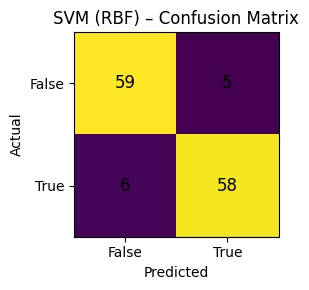

In [53]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
plt.imshow(cm, interpolation='nearest')
plt.title("SVM (RBF) – Confusion Matrix")
plt.xticks([0,1], ['False', 'True'])
plt.yticks([0,1], ['False', 'True'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, v, ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

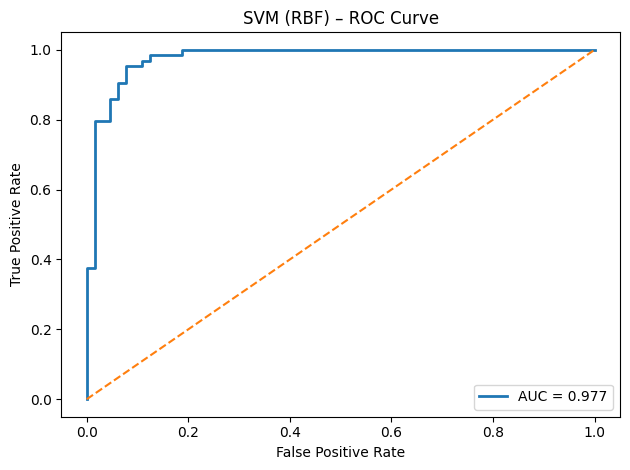

In [54]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], ls='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title("SVM (RBF) – ROC Curve")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

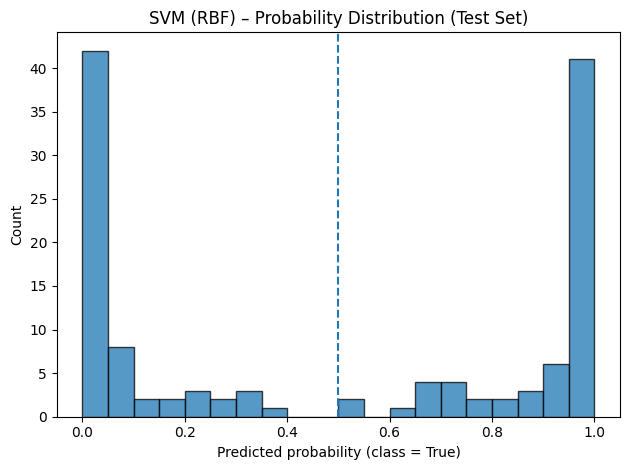

In [55]:
# Probability Distribution
plt.figure()
plt.hist(y_scores, bins=20, edgecolor='black', alpha=0.75)
plt.axvline(0.5, ls='--')
plt.xlabel('Predicted probability (class = True)')
plt.ylabel('Count')
plt.title("SVM (RBF) – Probability Distribution (Test Set)")
plt.tight_layout()
plt.show()

## KNN (k = 7) – Leave-One-Mouse-Out CV

In [56]:
# Build pipeline
knn = KNeighborsClassifier(
    n_neighbors=7,
    weights='uniform',
    metric='minkowski'
)

pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', knn)
])

In [57]:
# Leave-One-Mouse-Out CV (accuracy)
cv_acc = cross_val_score(
    pipe, X, y,
    cv=cv_groups,
    scoring='accuracy',
    n_jobs=-1
)
print(f"LOMO Accuracy: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")

LOMO Accuracy: 0.873 ± 0.099


In [58]:
# Fit on full training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['cell_specimen_id',
                                                   'mouse_id', 'AUC',
                                                   'PeakAmplitude',
                                                   'LatencyToPeak',
                                                   'TroughAmplitude',
                                                   'LatencyToTrough',
                                                   'PeakToTrough',
                                                   'Slope_0_200ms', 'FWHM',
                                                   'Energy', 'Mean_0_500ms',
                                                   'Mean_500_1000ms',
                                                   'Skewness', 'Kurtosis',
                                                   'ZeroCrossings',
                                                   'RiseTime_10to90',
                                                   'DecayTime_Half']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cre_line',
                                                   'exposure_level'])])),
                ('clf', KNeighborsClassifier(n_neighbors=7))])

In [59]:
# Predictions & probabilities on Test
y_pred   = pipe.predict(X_test)
# KNN has predict_proba in scikit-learn ≥0.24
y_scores = pipe.predict_proba(X_test)[:, 1]

In [60]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_scores)

In [61]:
print("Test-set metrics:")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1-Score : {f1:.3f}")
print(f"  ROC-AUC  : {roc:.3f}")

Test-set metrics:
  Accuracy : 0.898
  Precision: 0.918
  Recall   : 0.875
  F1-Score : 0.896
  ROC-AUC  : 0.958


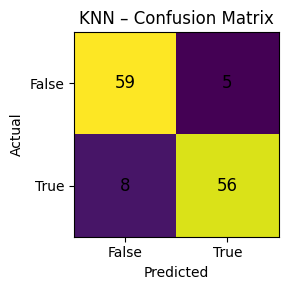

In [62]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
plt.imshow(cm, interpolation='nearest')
plt.title("KNN – Confusion Matrix")
plt.xticks([0,1], ['False', 'True'])
plt.yticks([0,1], ['False', 'True'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, v, ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

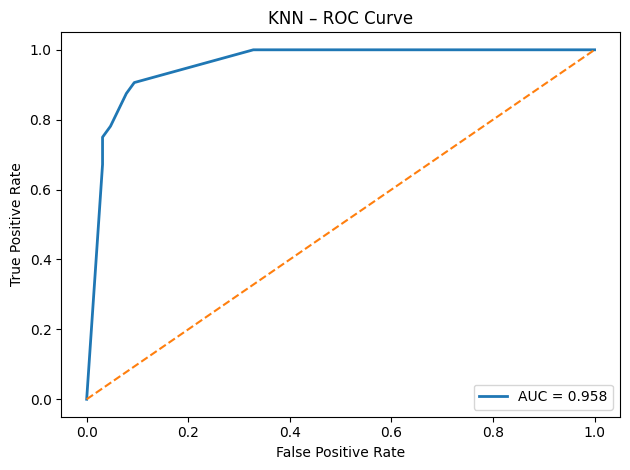

In [63]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], ls='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title("KNN – ROC Curve")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

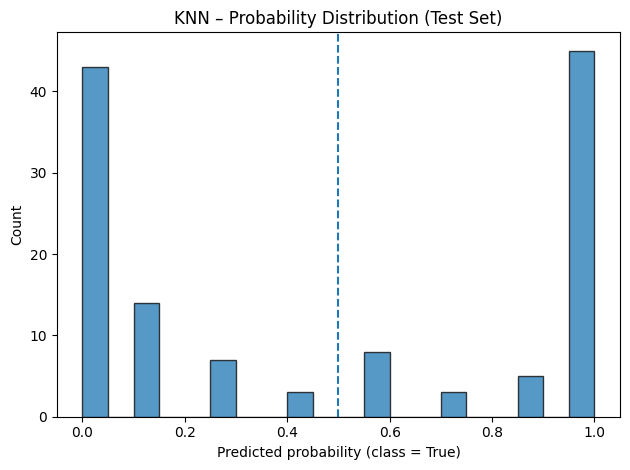

In [64]:
# Probability Distribution
plt.figure()
plt.hist(y_scores, bins=20, edgecolor='black', alpha=0.75)
plt.axvline(0.5, ls='--')
plt.xlabel('Predicted probability (class = True)')
plt.ylabel('Count')
plt.title("KNN – Probability Distribution (Test Set)")
plt.tight_layout()
plt.show()

## Gradient Boosting – Leave-One-Mouse-Out CV

In [65]:
# Build pipeline
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', gb)
])

In [66]:
# Leave-One-Mouse-Out CV (accuracy)
cv_acc = cross_val_score(
    pipe, X, y,
    cv=cv_groups,
    scoring='accuracy',
    n_jobs=-1
)
print(f"LOMO Accuracy: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")

LOMO Accuracy: 0.945 ± 0.053


In [67]:
# Fit on full training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['cell_specimen_id',
                                                   'mouse_id', 'AUC',
                                                   'PeakAmplitude',
                                                   'LatencyToPeak',
                                                   'TroughAmplitude',
                                                   'LatencyToTrough',
                                                   'PeakToTrough',
                                                   'Slope_0_200ms', 'FWHM',
                                                   'Energy', 'Mean_0_500ms',
                                                   'Mean_500_1000ms',
                                                   'Skewness', 'Kurtosis',
                                                   'ZeroCrossings',
                                                   'RiseTime_10to90',
                                                   'DecayTime_Half']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cre_line',
                                                   'exposure_level'])])),
                ('clf',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=200,
                                            random_state=42))])

In [68]:
# Predictions & probabilities on Test
y_pred   = pipe.predict(X_test)
y_scores = pipe.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_scores)

In [69]:
print("Test-set metrics:")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1-Score : {f1:.3f}")
print(f"  ROC-AUC  : {roc:.3f}")

Test-set metrics:
  Accuracy : 0.977
  Precision: 0.984
  Recall   : 0.969
  F1-Score : 0.976
  ROC-AUC  : 0.997


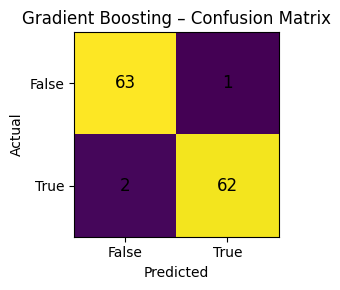

In [70]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
plt.imshow(cm, interpolation='nearest')
plt.title("Gradient Boosting – Confusion Matrix")
plt.xticks([0,1], ['False', 'True'])
plt.yticks([0,1], ['False', 'True'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, v, ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

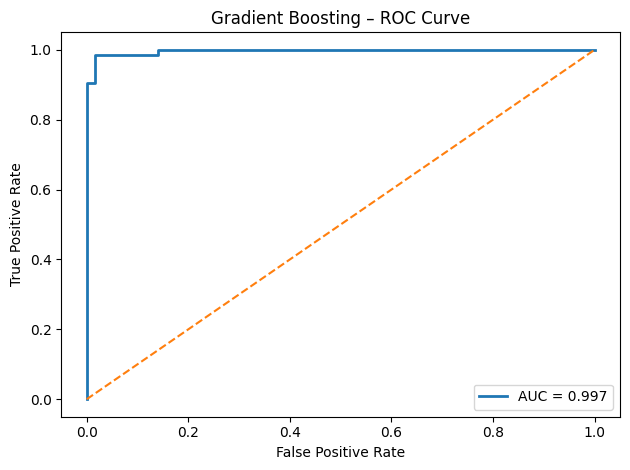

In [71]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], ls='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title("Gradient Boosting – ROC Curve")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

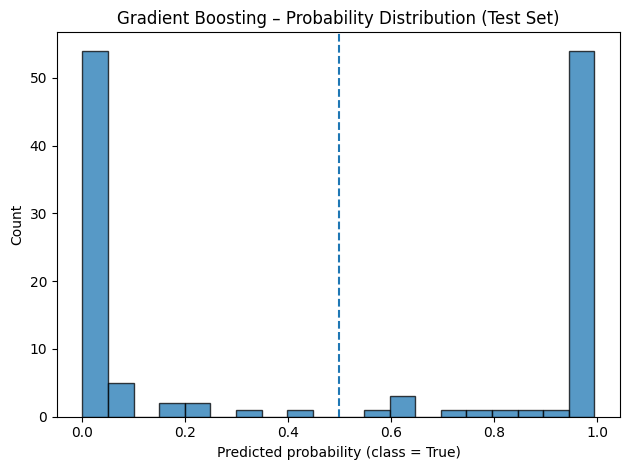

In [72]:
# Probability Distribution
plt.figure()
plt.hist(y_scores, bins=20, edgecolor='black', alpha=0.75)
plt.axvline(0.5, ls='--')
plt.xlabel('Predicted probability (class = True)')
plt.ylabel('Count')
plt.title("Gradient Boosting – Probability Distribution (Test Set)")
plt.tight_layout()
plt.show()

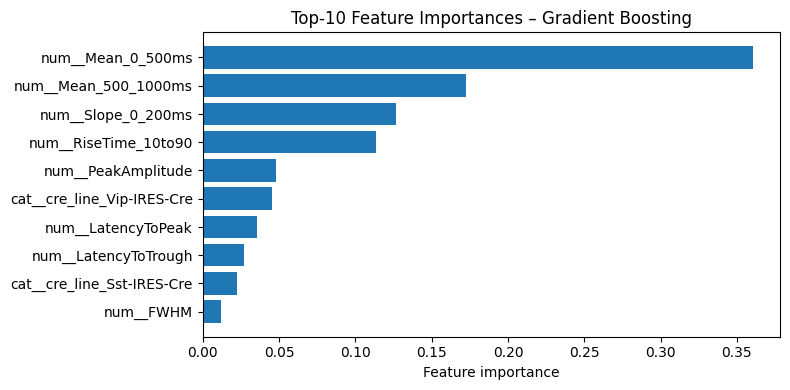

In [73]:
# ----------------------------------------------------------
# Top-10 feature importances – Gradient Boosting Classifier
# ----------------------------------------------------------
# Get feature names after preprocessing
try:
    feature_names = pipe.named_steps['preprocess'].get_feature_names_out()
except AttributeError:
    # Fallback for older scikit-learn versions
    num_feats = pipe.named_steps['preprocess'].transformers_[0][2]
    cat_encoder = pipe.named_steps['preprocess'].transformers_[1][1]
    cat_feats = cat_encoder.get_feature_names_out(pipe.named_steps['preprocess'].transformers_[1][2])
    feature_names = np.concatenate([num_feats, cat_feats])

# Pair with importances
importances = pipe.named_steps['clf'].feature_importances_
fi = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Select & sort top-10
top10 = fi.sort_values('importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(8,4))
plt.barh(top10['feature'][::-1], top10['importance'][::-1])
plt.xlabel('Feature importance')
plt.title('Top-10 Feature Importances – Gradient Boosting')
plt.tight_layout()
plt.show()


## XGBoost – Leave-One-Mouse-Out CV

In [74]:
# Build pipeline
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', xgb)
])

In [75]:
# Leave-One-Mouse-Out CV (accuracy)
cv_acc = cross_val_score(
    pipe, X, y,
    cv=cv_groups,
    scoring='accuracy',
    n_jobs=-1
)
print(f"LOMO Accuracy: {cv_acc.mean():.3f} ± {cv_acc.std():.3f}")

LOMO Accuracy: 0.947 ± 0.053


In [76]:
# Fit on full training data
pipe.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:17:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['cell_specimen_id',
                                                   'mouse_id', 'AUC',
                                                   'PeakAmplitude',
                                                   'LatencyToPeak',
                                                   'TroughAmplitude',
                                                   'LatencyToTrough',
                                                   'PeakToTrough',
                                                   'Slope_0_200ms', 'FWHM',
                                                   'Energy', 'Mean_0_500ms',
                                                   'Mean_500_1000ms',
                                                   'Skewness', 'Kurtosis',
                                                   'ZeroCrossings',
                                                   'RiseTime_10to90',
                                                   'DecayTime_Half']),
                                                 ('ca...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [77]:
# Predictions & probabilities on Test
y_pred   = pipe.predict(X_test)
y_scores = pipe.predict_proba(X_test)[:, 1]

In [78]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_scores)

In [79]:
print("Test-set metrics:")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1-Score : {f1:.3f}")
print(f"  ROC-AUC  : {roc:.3f}")

Test-set metrics:
  Accuracy : 0.969
  Precision: 0.969
  Recall   : 0.969
  F1-Score : 0.969
  ROC-AUC  : 0.996


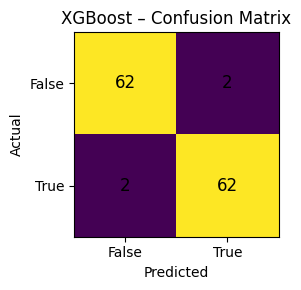

In [80]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
plt.imshow(cm, interpolation='nearest')
plt.title("XGBoost – Confusion Matrix")
plt.xticks([0,1], ['False', 'True'])
plt.yticks([0,1], ['False', 'True'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, v, ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

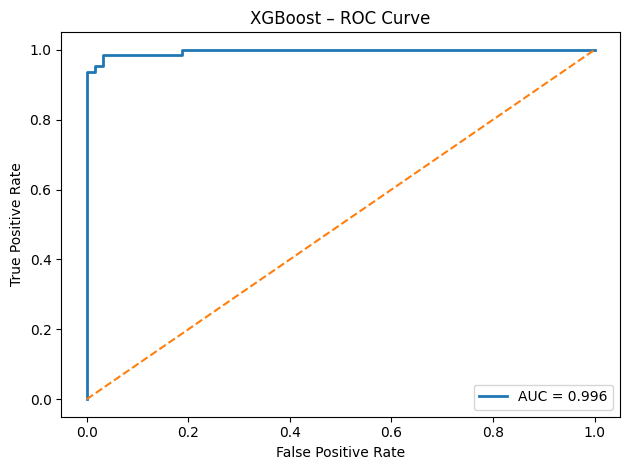

In [81]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], ls='--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title("XGBoost – ROC Curve")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

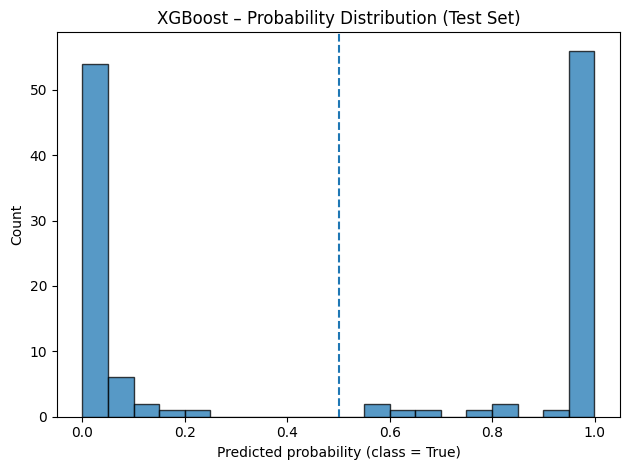

In [82]:
# Probability Distribution
plt.figure()
plt.hist(y_scores, bins=20, edgecolor='black', alpha=0.75)
plt.axvline(0.5, ls='--')
plt.xlabel('Predicted probability (class = True)')
plt.ylabel('Count')
plt.title("XGBoost – Probability Distribution (Test Set)")
plt.tight_layout()
plt.show()